## Using the N-Body Method
Having written an n-body right hand side function and bound the gravitational acceleration, lets try it out! You'll need to assemble the right hand side code into a file that can be imported. Move the ODE code you wrote into the same directory or create a package. Then experiment with the following algorithm/initial conditions.

### Euler Richardson

Begin by resurrecting your ODE code and doing some runs with initial conditions provided below' `euler`, `montgomery`, and `lagrange`. We know our best algorithm will be Euler-Richardson. 

#### Question:
Use Euler-Richardson integrate each of the initial conditions through 100 time units and plot the result. Adjust the time step to find a value where the orbit stable through the entire 100 unit interval. Note cases that can not be completed with stable orbits. Use the `time` module and function to determine the wall clock time required for the runs. Record the times and step requirements for future reference. Also, make an accounting of how many calls to the `n-body` function occur.

**Note:** I've tried to save you the hassle of writing plotting code. Writing this is tedious at best. The problem is, I don't think mine is especially tidy. If you feel like replacing mine with something better, by all means, go for it.

**Observation:** To ensure stability of orbits, these runs are requiring tens of seconds to minutes to make. Are we really condemned to such terrible performance?


## Better ODE Solutions: Runge Kutta 4

The simplest to implement, but steadiest performance for ODE integration can be realized with the *fourth order Runge-Kutta* methods. If you are in a situation where you have to implement the algorithm yourself, this provides the greatest return on your time. It also shows the way forward, which is weighted averages of slopes evaluated throughout the interval. The following equations have errors of order $\mathcal{O}(\Delta t^5)$, meaning the log of error vs log of time step plot sees error decrease with a slope of five. That's fast!

Here are the equations:

$$
\begin{align}
k_1 &=& &h f(x_n,y_n)\\
k_2 &=& &h f(x_n + \frac{1}{2}h,y_n + \frac{1}{2} k_1)\\
k_3 &=& &h f(x_n + \frac{1}{2}h,y_n + \frac{1}{2} k_2)\\
k_4 &=& &h f(x_n + h,y_n +  k_3)
\end{align}
$$

$$y_{n+1} = y_n + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4 $$

Where I've broken with previous convention to generalize ($t_n \rightarrow x_n$) and simplify ($\Delta t \rightarrow h$).

Add an implementation of these methods to your ODE code.

#### Question:
Use Runge-Kutta 4 to integrate each of the initial conditions through 100 time units and plot the result. Adjust the time and find a point where the orbit stable through the entire time interval. Note cases that can not be completed without instabilities. Use the `time` module and function to determine the time required. Record the times and time step requirements for future reference. Also, make an accounting of how many function calls occur.

### Runge Kutta 45

A major part of this assignment will be reading and implementing an algorithm that is outlined on the [numerical recipes web site](http://numerical.recipes/book/book.html). Numerical Recipes is a classic text for scientific computing methods. Not only are the methods well explained, the commentary is extremely insightful. 

In short, this algorithm will take the difference between 4th and a 5th order accurate estimates of $y_{n+1}$ and use that difference as an error estimate. The error estimate in turn, is used to control step size. The equations for the 5th order accurate estimate look like the following:

$$
\begin{align}
k_1 &= hf(x_n,y_n)\\
k_2 &= hf(x_n + c_2 h, y_n + a_{21}k_1)\\
&\cdots\\
k_6 &=  hf(x_n + c_6 h, y_n + a_{61}k_1+\cdots+ a_{65}k_5)\\
y_{n+1} &= y_n + b_1 k_1 + b_2 k_2 + b_3 k_3 + b_4 k_4 + b_5 k_5 + b_6 k_6 +\mathcal{O}(h^6)&
\end{align}
$$

Now, here is the remarkable feature of this algorithm: *the 4th order accurate estimate can be found using the same $k$ values, but different $b$ values.* The following formula makes that clear by writing the 4th order accurate solution as $y_{n+1}^*$:


$$
y^*_{n+1} = y_n + b^*_1 k_1 + b^*_2 k_2 + b^*_3 k_3 + b^*_4 k_4 + b^*_5 k_5 + b^*_6 k_6 +\mathcal{O}(h^5)
$$

Hence, the errors are 
$$
\Delta = y_{n+1} - y^*_{n+1} = \sum_{i=1}^6 (b_i - b_i^*)k_i
$$

The particular values for the constants were found by Dormand and Prince.

![](rk45_coefficients.png)

Additional implementation details are found in the Numerical Recipes reference.


### Questions
After successful implementation of the RK45 algorithm, answer the following question.

1. Make a complete run (100 time units) for each of the initial conditions provided below. Determine the `abs` and `rtol` values needed to get stable orbits on this time scale. Note cases that can not be completed without instabilities. Use the `time` module and function to determine the time required. Record the times and time step requirements for future reference. Create a table that has each of the three algorithms (`EulerRichardson`, `RK4`, `RK45`) as rows, and in the columns record the maximum `dt` or `atol` and`rtol`, the number of function calls, and the time required for execution. Write a brief statement about which of the algorithms you believe is best, and why.
2. For fun, complete all the initial conditions at the end of the page and include plots of their orbits. 
3. Examine the stability of the solutions to the three-body problem (`euler`,`mongomery`,`lagrange`,`skinny_pineapple`, `hand_in_oval`) by slightly varying the initial velocity of one of the masses by ~0.5%. Before passing your new initial state to the ODE solver, calculate the center of mass velocity and subtract this velocity from every object. Based on what you see, determine if the instability an inherit physical property, or the result of the ODE solver? Make a clear statement about which initial conditions are stable or unstable. Compute and monitor the conservation of the total energy (that is potential plus kinetic). Total energy can be computed from the ODE output and plotted.

Potential energy is

$$V_{ij} = -\frac{G m_i m_j}{r_{ij}}$$
where unlike force, potential energy *only counts once for each pair*. This would amount to the entries in the upper triangle of a $V$ matrix. Indeed, I think the way to compute this is with nested loops, quite similar to what was done for our forces in the n-body calculation.

Kinetic energy is

$$KE_i = \frac{1}{2} m_i v_i^2$$

for each body $i$.

The sum $KE +V$ for all particles is the total energy of the system. This should remain a constant through the simulation.

**Note on calculation:** Compute the potential, kinetic, and total energy from the final array of state vectors that are given back by the ODE solver.

In [ ]:
# # Obnoxious hack to get VSCode to run from the correct directory
# import os
# os.chdir("/var/home/jessej/Active/Teach/SimulationModeling/Assignments/Kinematics/n_body/")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
from integrators import *
from n_body_rhs import *
from n_body_ic import *
import time

In [ ]:
# Plot function, use or not, but can be helpful for debugging.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML

%matplotlib inline

def show_anim(t_s,y,trace_length=20,out_time=.05):  
    plt.style.use('dark_background')
    d = 2
    c=['tab:red','tab:olive','tab:pink','tab:cyan','tab:purple']
    body_list = []
    trace_list = []

    K = int(out_time/dt)
    t_sd = t_s[::K]
    yd   = y[::K,:]

    fig = plt.figure(figsize=(10,10));
    ax = plt.axes()

    x_min,x_max,y_min,y_max = 1e9,-1e9,1e9,-1e9
    for i in range(0,y0.size//d,d):
        x_t = yd[:,i]
        y_t = yd[:,i+1]
        if x_min > x_t.min(): x_min = x_t.min()
        if x_max < x_t.max(): x_max = x_t.max()
        if y_min > y_t.min(): y_min = y_t.min()
        if y_max < y_t.max(): y_max = y_t.max()

        ph, =  ax.plot(x_t,y_t,'-',color=[.7,.7,.7],linewidth=.7);

    plt.xlim([1.2*x_min,1.2*x_max])
    plt.ylim([1.2*y_min,1.2*y_max])

    ax.axis('off')

    for i in range(0,y0.size//d,d):
        ph, =  ax.plot(y0[i],y0[i+1],'o',color=c[i//d]); 
        body_list.append( ph )
        ph, = ax.plot([],[],'-',color=c[i//d])
        trace_list.append( ph )

    def animate(i):
        i = i % (t_sd.size-1)
        for im,j in zip(body_list,range(0,d*len(body_list),d)):
            im.set_xdata( [yd[i+1,j]] )
            im.set_ydata( [yd[i+1,j+1]] )

        if i>trace_length:
            for im,j in zip(trace_list,range(0,d*len(trace_list),d)):
                im.set_xdata( yd[i-trace_length:i+1,j] )
                im.set_ydata( yd[i-trace_length:i+1,j+1] )
        return im

    anim = animation.FuncAnimation(fig, animate, interval=20,frames=t_sd.size-1) 
    return anim


# Function to compute the total energy given state array (state vector for a sequence of times.)
def total_energy(y,p):
    """
    INPUTS:
    y - the output of the ODE solver
    p - the parameters dictionary
    OUTPUT:
    the total energy at each time y is provided.
    """
    steps,dofs = y.shape
    d = p['dimension']
    half = dofs // 2
    
    KE=V=np.zeros(steps)
    # This loop determines total potential energy, works on the
    # first half of data in y, the positions.
    for i in range(0,half,d):
        ri = y[:,i:i+d]
        for j in range(i+d,half,d):
            rj = y[:,j:j+d]
            rij  = np.linalg.norm(ri - rj ,axis=1)
            V += - p['G'] * p['m'][i//d] * p['m'][j//d] / rij
    # This loop determines kinetic energy for each body, works on later half 
    # of y, or the velocities.
    for i in range(half,dofs,d):
        KE += 0.5 * p['m'][(i-half)//d] * np.sum(y[:,i:i+d]**2,1)
        
    return KE + V

In [ ]:
def plot_3body(y):
    # show trajectories of all bodies on the same plot
    plt.plot(y[:,0],y[:,1],label='body1')
    plt.plot(y[:,2],y[:,3],label='body2')
    plt.plot(y[:,4],y[:,5],label='body3')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def plot_4body(y):
    # show trajectories of all bodies on the same plot
    plt.plot(y[:,0],y[:,1],label='body1')
    plt.plot(y[:,2],y[:,3],label='body2')
    plt.plot(y[:,4],y[:,5],label='body3')
    plt.plot(y[:,6],y[:,7],label='body4')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [ ]:
from integrators import *
from n_body_rhs import *
from n_body_ic import *
import time

y0 = euler
p  = p3
dt = .01 
t_span = [0,100]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, EulerRichardson, args=(p,),first_step=dt)

end_t = time.time()
print("Elapsed time = %4.3f seconds."%(end_t-start_t))

# plot_3body(y)

plt.style.use("seaborn-v0_8")
plt.axis("on")
anim = show_anim(t_s,y)
HTML(anim.to_html5_video())

# E = total_energy(y,p)
# plt.plot(E,'r')
# small = 1e-3
# plt.ylim(E.min()*(1-small),E.max()*(1+small))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import HTML

# Create a function counter class
class FunctionCounter:
    def __init__(self, func):
        self.func = func
        self.calls = 0
        self.name = func.__name__
    
    def __call__(self, *args, **kwargs):
        self.calls += 1
        return self.func(*args, **kwargs)
    
    def reset(self):
        self.calls = 0

# Wrap the n_body function with our counter
n_body_counter = FunctionCounter(n_body)

# Modify the solve_ode function to return the function call count
def solve_ode_with_count(f, tspan, y0, method=Euler, args=(), **options):
    """
    Same as solve_ode but also returns the number of function calls
    """
    t0 = tspan[0]
    tf = tspan[1]
    y = [y0]
    t = [t0]
    dt = options.get('first_step', 0.1)
    
    while t[-1] < tf:
        y.append(method(dt, f, t[-1], y[-1], args))
        t.append(t[-1] + dt)
    
    # If f is a FunctionCounter, return the call count
    call_count = getattr(f, 'calls', None)
    
    return np.array(t), np.array(y), call_count

# Function to compare different integration methods
def compare_methods(y0, t_span, p, dt=0.01):
    methods = [Euler, EulerCromer, EulerRichardson, RK4]
    method_names = ["Euler", "Euler-Cromer", "Euler-Richardson", "RK4"]
    results = []
    
    for method, name in zip(methods, method_names):
        # Reset the counter
        n_body_counter.reset()
        
        # Time the integration
        start_t = time.time()
        t_s, y, calls = solve_ode_with_count(n_body_counter, t_span, y0, method, args=(p,), first_step=dt)
        end_t = time.time()
        
        # Calculate elapsed time
        elapsed = end_t - start_t
        
        print(f"{name}: {calls} function calls, {elapsed:.3f} seconds")
        
        # Store results
        results.append({
            'method': name,
            'time_points': t_s,
            'solution': y,
            'calls': calls,
            'elapsed': elapsed
        })
    
    return results

# Function to visualize call counts
def plot_function_calls(results):
    method_names = [r['method'] for r in results]
    call_counts = [r['calls'] for r in results]
    elapsed_times = [r['elapsed'] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot function calls
    ax1.bar(method_names, call_counts, color='skyblue')
    ax1.set_title('Number of Function Calls by Method')
    ax1.set_xlabel('Method')
    ax1.set_ylabel('Function Calls')
    
    # Add text labels on bars
    for i, v in enumerate(call_counts):
        ax1.text(i, v + 0.5, str(v), ha='center')
    
    # Plot elapsed time
    ax2.bar(method_names, elapsed_times, color='salmon')
    ax2.set_title('Computation Time by Method')
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Time (seconds)')
    
    # Add text labels on bars
    for i, v in enumerate(elapsed_times):
        ax2.text(i, v + 0.02, f"{v:.3f}s", ha='center')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# results = compare_methods(y0, t_span, p, dt=0.01)
# plot_function_calls(results)

# Single method run with count tracking
def run_simulation(y0, t_span, p, method=RK4, dt=0.01):
    n_body_counter.reset()
    start_t = time.time()
    t_s, y, calls = solve_ode_with_count(n_body_counter, t_span, y0, method, args=(p,), first_step=dt)
    end_t = time.time()
    
    print(f"Method: {method.__name__}")
    print(f"Function calls: {calls}")
    print(f"Elapsed time: {end_t-start_t:.3f} seconds")
    print(f"Average calls per time step: {calls / len(t_s):.2f}")
    
    return t_s, y, calls

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from matplotlib.gridspec import GridSpec

# Create a function counter class
class FunctionCounter:
    def __init__(self, func):
        self.func = func
        self.calls = 0
        self.name = func.__name__
    
    def __call__(self, *args, **kwargs):
        self.calls += 1
        return self.func(*args, **kwargs)
    
    def reset(self):
        self.calls = 0

# Wrap the n_body function with our counter
n_body_counter = FunctionCounter(n_body)

# Calculate total energy of n-body system (kinetic + potential)
def calculate_energy(y, p):
    """
    Calculate the total energy (kinetic + potential) of the n-body system
    
    Parameters:
    -----------
    y : ndarray
        State vector containing positions and velocities
    p : dict
        Parameter dictionary containing masses, G, and dimension
        
    Returns:
    --------
    total_energy : float
        Total energy of the system
    kinetic_energy : float
        Kinetic energy of the system
    potential_energy : float
        Potential energy of the system
    """
    G = p['G']
    masses = p['m']
    n = len(masses)
    d = p['dimension']
    
    # Unpack state
    positions = y[:n*d].reshape((n, d))
    velocities = y[n*d:].reshape((n, d))
    
    # Calculate kinetic energy: K = 0.5 * m * v^2
    kinetic_energy = 0.0
    for i in range(n):
        if p.get("fix_first", False) and i == 0:
            continue  # Skip first body if fixed
        v_squared = np.sum(velocities[i]**2)
        kinetic_energy += 0.5 * masses[i] * v_squared
    
    # Calculate potential energy: U = -G * m_i * m_j / r_ij
    potential_energy = 0.0
    for i in range(n):
        for j in range(i+1, n):
            r_vec = positions[i] - positions[j]
            r = np.linalg.norm(r_vec)
            potential_energy -= G * masses[i] * masses[j] / r
    
    total_energy = kinetic_energy + potential_energy
    return total_energy, kinetic_energy, potential_energy

# Calculate angular momentum
def calculate_angular_momentum(y, p):
    """
    Calculate the total angular momentum of the n-body system
    
    Parameters:
    -----------
    y : ndarray
        State vector containing positions and velocities
    p : dict
        Parameter dictionary containing masses, G, and dimension
        
    Returns:
    --------
    angular_momentum : float or ndarray
        Total angular momentum of the system
    """
    masses = p['m']
    n = len(masses)
    d = p['dimension']
    
    # Unpack state
    positions = y[:n*d].reshape((n, d))
    velocities = y[n*d:].reshape((n, d))
    
    angular_momentum = np.zeros(3)  # 3D vector even for 2D simulation
    
    for i in range(n):
        if p.get("fix_first", False) and i == 0:
            continue  # Skip first body if fixed
            
        # For 2D, we pad with zeros for cross product
        pos = np.zeros(3)
        vel = np.zeros(3)
        
        pos[:d] = positions[i]
        vel[:d] = velocities[i]
        
        # L = r × p = r × mv
        L_i = masses[i] * np.cross(pos, vel)
        angular_momentum += L_i
    
    # For 2D, we only care about the z-component
    if d == 2:
        return angular_momentum[2]
    
    return angular_momentum

# Modify the solve_ode function to track energy and return the function call count
def solve_ode_with_stability(f, tspan, y0, method=Euler, args=(), **options):
    """
    Same as solve_ode but tracks stability metrics and returns call count
    """
    t0 = tspan[0]
    tf = tspan[1]
    y = [y0]
    t = [t0]
    dt = options.get('first_step', 0.1)
    
    # Initialize stability metrics
    p = args[0] if args else {}  # Extract parameters if provided
    
    # Calculate initial energy and angular momentum
    if p:
        initial_energy, _, _ = calculate_energy(y0, p)
        initial_angular_momentum = calculate_angular_momentum(y0, p)
        
        # Track energy and angular momentum over time
        energies = [initial_energy]
        angular_momenta = [initial_angular_momentum]
    
    while t[-1] < tf:
        y.append(method(dt, f, t[-1], y[-1], args))
        t.append(t[-1] + dt)
        
        # Track energy and angular momentum
        if p:
            energy, _, _ = calculate_energy(y[-1], p)
            angular_momentum = calculate_angular_momentum(y[-1], p)
            
            energies.append(energy)
            angular_momenta.append(angular_momentum)
    
    # If f is a FunctionCounter, return the call count
    call_count = getattr(f, 'calls', None)
    
    # Pack stability metrics
    stability_metrics = {
        'energies': np.array(energies) if p else None,
        'energy_drift': np.array(energies) - initial_energy if p else None,
        'angular_momenta': np.array(angular_momenta) if p else None,
        'angular_momentum_drift': np.array(angular_momenta) - initial_angular_momentum if p else None,
    }
    
    return np.array(t), np.array(y), call_count, stability_metrics

# Function to compare different integration methods
def compare_methods_with_stability(y0, t_span, p, dt=0.01):
    methods = [Euler, EulerCromer, EulerRichardson, RK4]
    method_names = ["Euler", "Euler-Cromer", "Euler-Richardson", "RK4"]
    results = []
    
    for method, name in zip(methods, method_names):
        # Reset the counter
        n_body_counter.reset()
        
        # Time the integration
        start_t = time.time()
        t_s, y, calls, stability = solve_ode_with_stability(
            n_body_counter, t_span, y0, method, args=(p,), first_step=dt
        )
        end_t = time.time()
        
        # Calculate elapsed time
        elapsed = end_t - start_t
        
        print(f"{name}: {calls} function calls, {elapsed:.3f} seconds")
        
        # Calculate final position distances - get last state
        final_state = y[-1]
        
        # Store results
        results.append({
            'method': name,
            'time_points': t_s,
            'solution': y,
            'calls': calls,
            'elapsed': elapsed,
            'final_state': final_state,
            'stability': stability
        })
    
    return results

# Function to visualize stability metrics
def plot_stability_comparison(results, p, title="Stability Comparison"):
    n = len(p['m'])
    d = p['dimension']
    
    # Set up the figure
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # Plot 1: Energy drift over time
    ax1 = fig.add_subplot(gs[0, 0])
    for result in results:
        stability = result['stability']
        if stability['energies'] is not None:
            relative_energy_drift = stability['energy_drift'] / np.abs(stability['energies'][0])
            ax1.plot(result['time_points'], relative_energy_drift, label=result['method'])
    
    ax1.set_title('Relative Energy Drift')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('ΔE/E₀')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Angular momentum drift over time
    ax2 = fig.add_subplot(gs[0, 1])
    for result in results:
        stability = result['stability']
        if stability['angular_momenta'] is not None:
            if np.abs(stability['angular_momenta'][0]) > 1e-10:  # Avoid division by zero
                relative_am_drift = stability['angular_momentum_drift'] / np.abs(stability['angular_momenta'][0])
                ax2.plot(result['time_points'], relative_am_drift, label=result['method'])
    
    ax2.set_title('Relative Angular Momentum Drift')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('ΔL/L₀')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Final orbits
    ax3 = fig.add_subplot(gs[1:, 0])
    colors = plt.cm.tab10(np.linspace(0, 1, n))
    
    for i, result in enumerate(results):
        y = result['solution']
        final_positions = y[:, :n*d]
        
        for j in range(n):
            body_positions = final_positions[:, j*d:(j+1)*d]
            ax3.plot(body_positions[:, 0], body_positions[:, 1], 
                     alpha=0.5, label=f"{result['method']} - Body {j+1}")
            
            # Mark the final position
            ax3.scatter(body_positions[-1, 0], body_positions[-1, 1], 
                       s=100, marker='*', color=colors[j], 
                       edgecolor='black', label=f"Final Pos - Body {j+1}")
    
    ax3.set_title('Orbital Trajectories')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.axis('equal')
    ax3.grid(True)
    
    # Plot 4: Final position differences
    ax4 = fig.add_subplot(gs[1:, 1])
    
    # For each body, calculate distance between final positions across methods
    for j in range(n):
        position_diffs = []
        method_pairs = []
        
        # Compare each pair of methods
        for i, result1 in enumerate(results):
            for k, result2 in enumerate(results[i+1:], i+1):
                pos1 = result1['final_state'][j*d:(j+1)*d]
                pos2 = result2['final_state'][j*d:(j+1)*d]
                
                # Calculate Euclidean distance
                diff = np.linalg.norm(pos1 - pos2)
                position_diffs.append(diff)
                method_pairs.append(f"{result1['method']} vs {result2['method']}")
        
        # Plot as bar chart
        bar_positions = np.arange(len(position_diffs)) + j*0.2
        ax4.bar(bar_positions, position_diffs, width=0.2, alpha=0.7, 
                label=f"Body {j+1}", color=colors[j])
    
    # Set x-ticks in the middle of grouped bars
    ticks_pos = np.arange(len(method_pairs)) + (n-1)*0.1
    ax4.set_xticks(ticks_pos)
    ax4.set_xticklabels(method_pairs, rotation=45, ha='right')
    
    ax4.set_title('Final Position Differences Between Methods')
    ax4.set_xlabel('Method Comparison')
    ax4.set_ylabel('Euclidean Distance')
    ax4.legend()
    ax4.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Print summary statistics
    print("\nStability Metrics Summary:")
    print("--------------------------")
    for result in results:
        stability = result['stability']
        if stability['energies'] is not None:
            max_energy_drift = np.max(np.abs(stability['energy_drift'] / np.abs(stability['energies'][0])))
            print(f"{result['method']}: Max Relative Energy Drift = {max_energy_drift:.6e}")

# Function to analyze a single method's stability in detail
def analyze_stability(y0, t_span, p, method=RK4, dt=0.01):
    # Reset counter
    n_body_counter.reset()
    
    # Run simulation with stability tracking
    start_t = time.time()
    t_s, y, calls, stability = solve_ode_with_stability(
        n_body_counter, t_span, y0, method, args=(p,), first_step=dt
    )
    end_t = time.time()
    
    n = len(p['m'])
    d = p['dimension']
    
    # Print summary
    print(f"Method: {method.__name__}")
    print(f"Function calls: {calls}")
    print(f"Elapsed time: {end_t-start_t:.3f} seconds")
    
    # Detailed stability analysis
    fig = plt.figure(figsize=(15, 10))
    
    # Energy components
    ax1 = fig.add_subplot(221)
    
    # Calculate energy components for each time step
    kinetic = []
    potential = []
    total = []
    
    for state in y:
        total_e, kinetic_e, potential_e = calculate_energy(state, p)
        kinetic.append(kinetic_e)
        potential.append(potential_e)
        total.append(total_e)
    
    ax1.plot(t_s, kinetic, label='Kinetic')
    ax1.plot(t_s, potential, label='Potential')
    ax1.plot(t_s, total, label='Total')
    
    ax1.set_title(f'Energy Components ({method.__name__})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Energy')
    ax1.legend()
    ax1.grid(True)
    
    # Energy drift
    ax2 = fig.add_subplot(222)
    initial_energy = total[0]
    rel_energy_drift = [(e - initial_energy)/abs(initial_energy) for e in total]
    
    ax2.plot(t_s, rel_energy_drift)
    ax2.set_title('Relative Energy Drift')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('ΔE/E₀')
    ax2.grid(True)
    
    # Body trajectories
    ax3 = fig.add_subplot(223)
    colors = plt.cm.tab10(np.linspace(0, 1, n))
    
    for i in range(n):
        positions = y[:, i*d:(i+1)*d]
        ax3.plot(positions[:, 0], positions[:, 1], color=colors[i], label=f'Body {i+1}')
        
        # Mark initial position
        ax3.scatter(positions[0, 0], positions[0, 1], s=100, marker='o', 
                   color=colors[i], edgecolor='black')
        
        # Mark final position
        ax3.scatter(positions[-1, 0], positions[-1, 1], s=100, marker='*', 
                   color=colors[i], edgecolor='black')
    
    ax3.set_title('Body Trajectories')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.legend()
    ax3.axis('equal')
    ax3.grid(True)
    
    # Angular momentum
    ax4 = fig.add_subplot(224)
    if d == 2:  # Only for 2D
        angular_m = stability['angular_momenta']
        initial_am = angular_m[0]
        
        if abs(initial_am) > 1e-10:  # Avoid division by zero
            rel_am_drift = [(am - initial_am)/abs(initial_am) for am in angular_m]
            ax4.plot(t_s, rel_am_drift)
            ax4.set_title('Relative Angular Momentum Drift')
            ax4.set_xlabel('Time')
            ax4.set_ylabel('ΔL/L₀')
        else:
            ax4.plot(t_s, angular_m)
            ax4.set_title('Angular Momentum')
            ax4.set_xlabel('Time')
            ax4.set_ylabel('L')
    
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nStability Metrics:")
    print("------------------")
    max_energy_drift = max(abs(e) for e in rel_energy_drift)
    print(f"Maximum absolute relative energy drift: {max_energy_drift:.6e}")
    
    if d == 2 and abs(initial_am) > 1e-10:
        max_am_drift = max(abs(am) for am in rel_am_drift)
        print(f"Maximum absolute relative angular momentum drift: {max_am_drift:.6e}")
    
    return t_s, y, stability

# Example usage
# euler = np.array([0,0,1,0,-1,0,0,0,0,.8,0,-.8])
# p3 = {'m':np.array([1,1,1]),'G':1,'dimension':2,'force':g_force,'fix_first':False}
# t_span = [0, 100]
# dt = 0.01

# Run a single method analysis
# t_s, y, stability = analyze_stability(euler, t_span, p3, method=RK4, dt=dt)

# Compare all methods
# results = compare_methods_with_stability(euler, t_span, p3, dt=dt)
# plot_stability_comparison(results, p3, title="Euler Initial Conditions Stability Comparison")

Euler: 100001 function calls, 13.272 seconds
Euler-Cromer: 200002 function calls, 17.656 seconds
Euler-Richardson: 200002 function calls, 17.718 seconds
RK4: 400004 function calls, 26.487 seconds


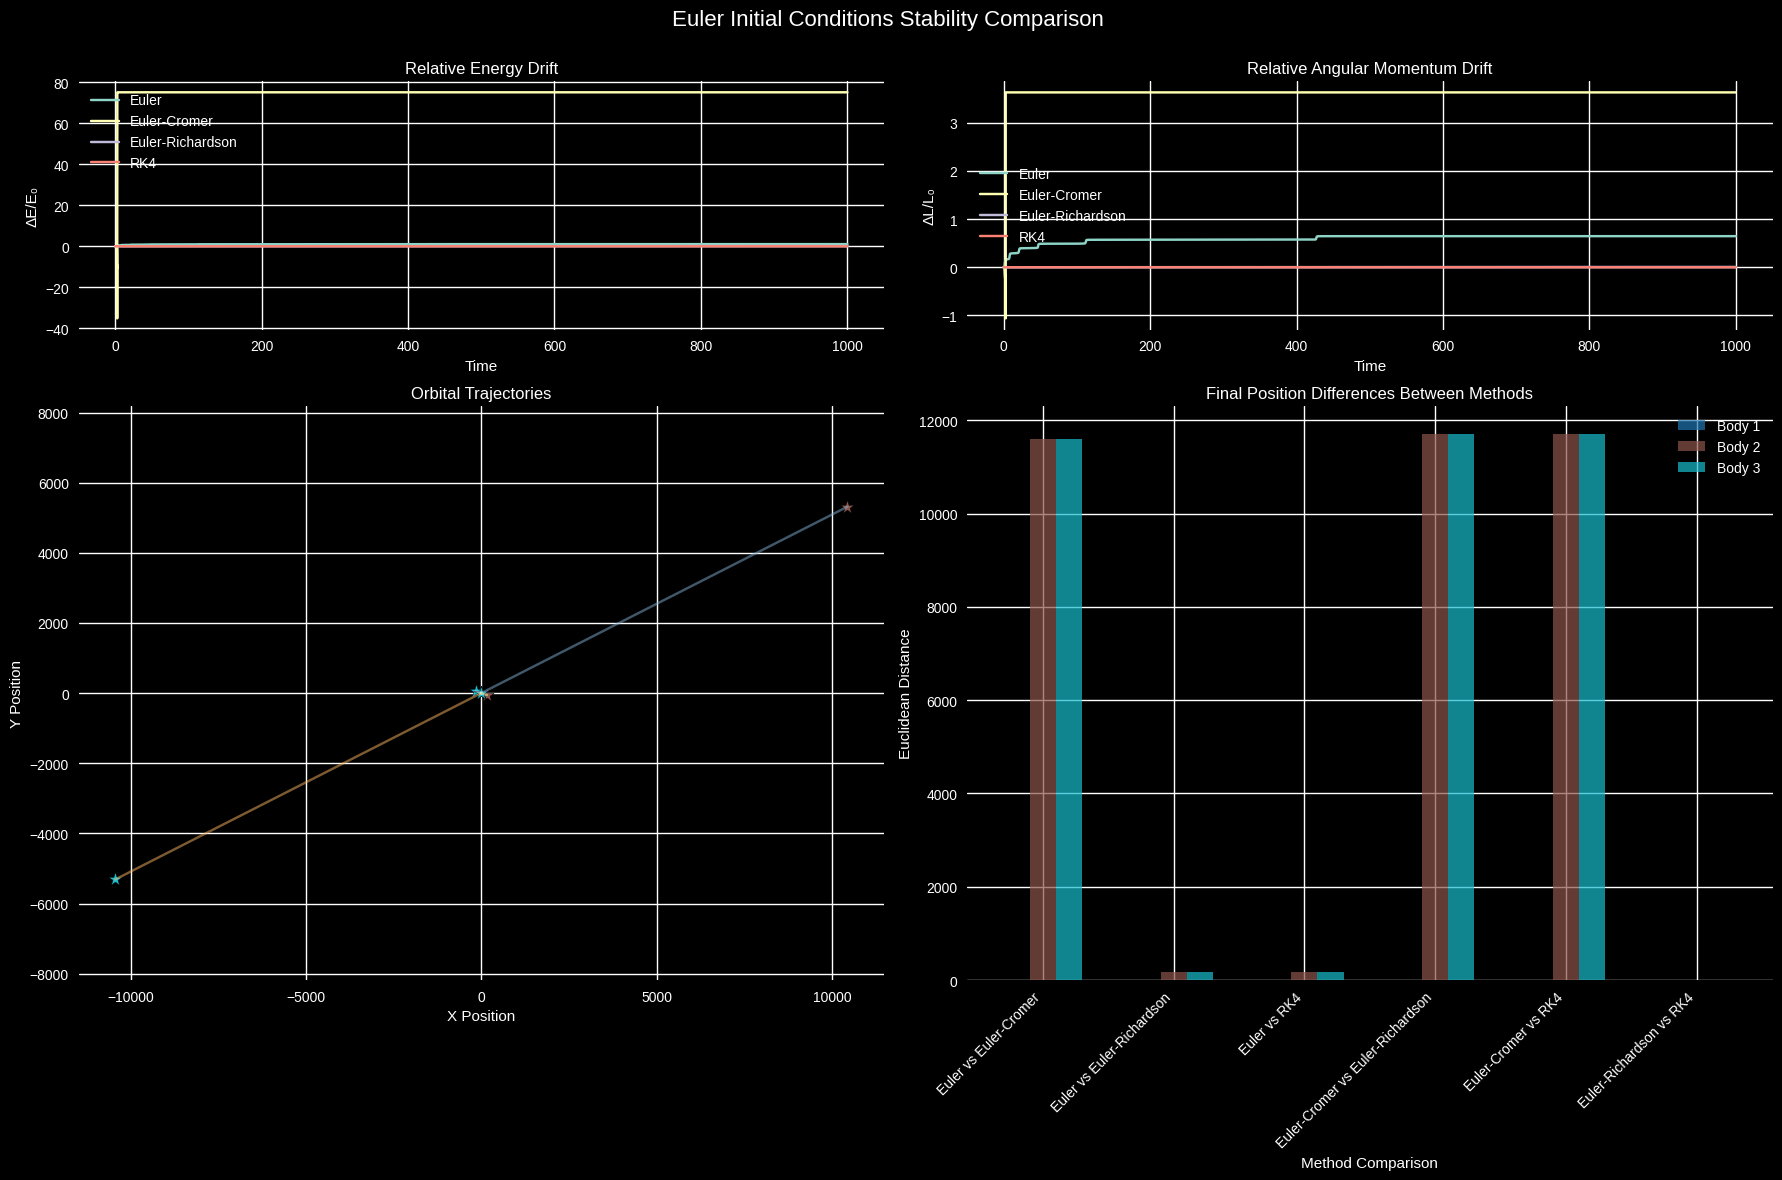


Stability Metrics Summary:
--------------------------
Euler: Max Relative Energy Drift = 1.025074e+00
Euler-Cromer: Max Relative Energy Drift = 7.518612e+01
Euler-Richardson: Max Relative Energy Drift = 6.393727e-02
RK4: Max Relative Energy Drift = 2.731413e-05


In [27]:
results = compare_methods_with_stability(euler, t_span, p3, dt=dt)
plot_stability_comparison(results, p3, title="Euler Initial Conditions Stability Comparison")

In [ ]:
# Compare all methods
results = compare_methods(y0, t_span, p, dt=0.01)
plot_function_calls(results)

---

### RK45

In [ ]:
y0 = montgomery
p  = p3
dt = .01
t_span = [0,10]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, RK45, args=(p,),atol=1e-10,rtol=1e-14,first_step=dt)
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))
# plot_3body(y)
anim = show_anim(t_s,y)
HTML(anim.to_html5_video())
# plt.style.use("seaborn-v0_8")
# plt.axis("on")
# E = total_energy(y,p)
# #plt.plot(E,'r')
# small = 1e-7
# plt.ylim(E.min()*(1-small),E.max()*(1+small))

In [ ]:
y0 = lagrange
p  = p3
dt = .05
t_span = [0,100]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, RK45, p,first_step=dt,\
                 rtol = 1e-10,atol=1e-14)
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))
anim = show_anim(t_s,y)

HTML(anim.to_html5_video())


In [ ]:
plt.style.use('seaborn')
plt.axis("on")
E = total_energy(y,p)
plt.plot(E,'r')
small = 1e-8
plt.ylim(E.min()*(1-small),E.max()*(1+small))

In [ ]:
# More initial conditions to experiment with:

skinny_pinapple = array([0.419698802831,1.190466261252,\
                        0.076399621771,  0.296331688995,\
                        0.100310663856, -0.729358656127,\
                        0.102294566003,  0.687248445943,\
                        0.148950262064,  0.240179781043,\
                       -0.251244828060, -0.927428226977])

hand_in_hand_oval = array([0.906009977921, 0.347143444587,\
                          -0.263245299491, 0.140120037700,\
                          -0.252150695248, -0.661320078799,\
                           0.242474965162, 1.045019736387,\
                          -0.360704684300, -0.807167979922,\
                           0.118229719138, -0.237851756465])

four_body = array([1.382857,0,\
                   0,0.157030,\
                  -1.382857,0,\
                   0,-0.157030,\
                   0,0.584873,\
                   1.871935,0,\
                   0,-0.584873,\
                  -1.871935,0])

helium_1 = array([0,0,2,0,-1,0,0,0,0,.95,0,-1])s
helium_2 = array([0,0,3,0,1,0,0,0,0,.4,0,-1])

# You'll have to tailor some of the parameters to the simulation - something like the following

p4 = {'m':array([1,1,1,1]),'G':1,'dimension':2,'force':gravitational,'fix_first':False}
p3 = {'m':array([1,1,1]),'G':1,'dimension':2,'force':gravitational,'fix_first':False}
p_he = {'m':array([2,-1,-1]),'G':1,'dimension':2,'force':gravitational,'fix_first':True}



### Bounties
* Show an implementation of RK4
* Show a method of counting function calls.
* Reconcile time step with adaptive time stepping.
* Show how FSAL works
* Define the estimation of errors in RK45.
* Define the adaptive step size in RK45.
* Walk through the looping in a function to determine the total energy.